In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.ticker as ticker
from scipy.integrate import simps



In [67]:
def get_simulation_data(df):
    df['simulation'] = 0
    times = df['time'].unique()
    times = np.sort(times)
    time_between_events = np.ediff1d(times)
    avg_time_between_events = np.average(time_between_events)
    avg_frequency = 1 / avg_time_between_events
    max_time_with_two_balls = df.groupby('iter').agg({'ball_id':'count', 'time':'first'}).query('ball_id == 2')['time'].max()
    return {
        'dataframe': df,
        'event_times': times,
        'time_between_events': time_between_events,
        'avg_time_between_events': avg_time_between_events,
        'avg_event_frequency': avg_frequency,
        'last_event_time': times.max(),
        'max_time_with_two_balls': max_time_with_two_balls,
    }

In [5]:
def get_ball_y_init_position(df):
    return df[(df['iter'] == 0) & (df['ball_id'] == 0)].iloc[0, :]['pos_y']

In [32]:
def plot_map(name,plot_map, xlabel, ylabel, log_scale, truncate_error):
    positions = [position for position in plot_map.keys()]
    values = [value[0] for value in plot_map.values()]
    errors = [value[1] for value in plot_map.values()]

    if truncate_error:
        errores_log = np.maximum(1e-10, errors)
        errors = np.log10(1 + errores_log/values)
        
    plt.errorbar(positions, values, yerr=errors, fmt='o', color='black', ecolor='red', capsize=3)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if log_scale:
        plt.yscale("log")
    plt.ylim(0, None)  
    plt.grid(True)
    plt.savefig(name)
    plt.clf()

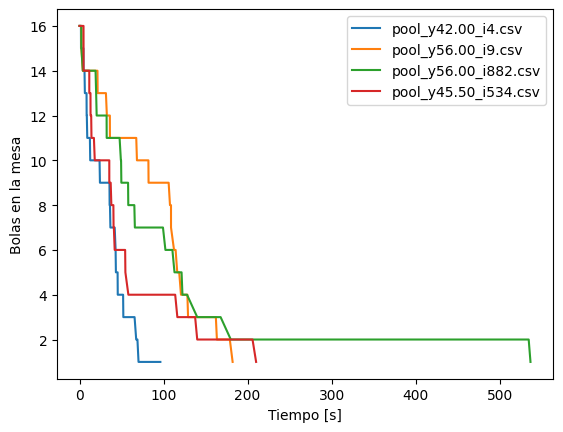

In [75]:
def draw_balls_in_table_over_time(df):
    return df.groupby(['time'])['ball_id'].count()
    
paths = ["../tp3/out/csv/pool_y42.00_i4.csv",
         "../tp3/out/csv/pool_y56.00_i9.csv",
         "../tp3/out/csv/pool_y56.00_i882.csv",
         "../tp3/out/csv/pool_y45.50_i534.csv"]


for path in paths:
    df = pd.read_csv(path)
    df_over_time = draw_balls_in_table_over_time(df)
    
    plt.plot(df_over_time, label=path.split('/')[-1])
    
plt.xlabel('Tiempo [s]')
plt.ylabel('Bolas en la mesa')
plt.legend()

Analyzing ../tp3/out/csv/pool_y42.00_i4.csv
Frequency: 2.3085599854822774
Analyzing ../tp3/out/csv/pool_y56.00_i9.csv
Frequency: 1.0429608415521483
Analyzing ../tp3/out/csv/pool_y56.00_i882.csv
Frequency: 0.3167564455981882
Analyzing ../tp3/out/csv/pool_y45.50_i534.csv
Frequency: 1.1707425943178076


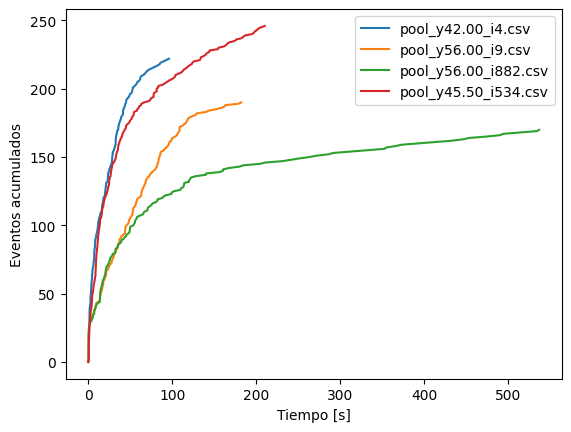

In [74]:
def draw_cumulative_events_over_time(df):
    return df.groupby(['time'])['iter'].max().reset_index()['time'].reset_index()

paths = ["../tp3/out/csv/pool_y42.00_i4.csv",
         "../tp3/out/csv/pool_y56.00_i9.csv",
         "../tp3/out/csv/pool_y56.00_i882.csv",
         "../tp3/out/csv/pool_y45.50_i534.csv"]


for path in paths:
    print("Analyzing " + path)
    df = pd.read_csv(path)
    
    print("Frequency: " + str(get_simulation_data(df)['avg_event_frequency']))
          
    df_over_time = draw_cumulative_events_over_time(df)
    
    plt.plot(df_over_time['time'], df_over_time['index'], label=path.split('/')[-1])

plt.xlabel('Tiempo [s]')
plt.ylabel('Eventos acumulados')
plt.legend()


Tiempo medio entre eventos: 0.9174887278106512
Frecuencia media entre eventos: 1.0899316467748226


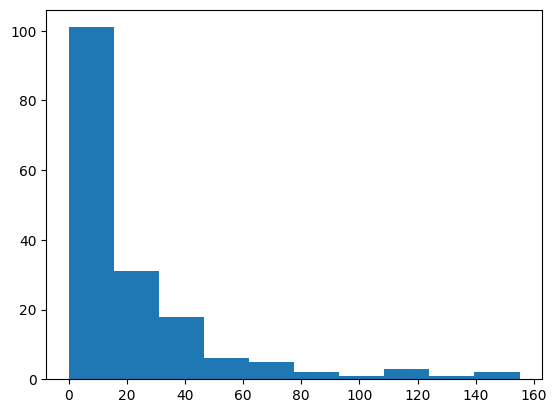

In [237]:
# Histograma de los tiempos en que ocurren los eventos para una 
# simuilacion en particular. 

df = pd.read_csv("../tp3/out/csv/pool_y42.00_i4.csv")
simulation_data = get_simulation_data(df)

# 1.2 distribucion
plt.hist(simulation_data['event_times'], bins=10 )

# 1.2 tiempo medio y frecuencia media
print(f"Tiempo medio entre eventos: {simulation_data['avg_time_between_events']}")
print(f"Frecuencia media entre eventos: {simulation_data['avg_event_frequency']}")

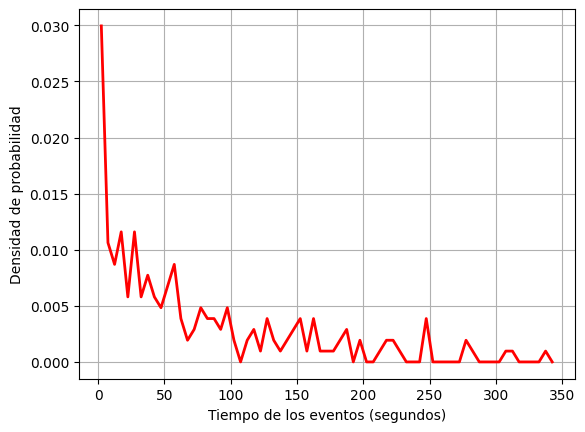

In [185]:

# Aproximacion de la PDF para la variable x que mide
# el tiempo en que ocurren los eventos.

df = pd.read_csv("../tp3/out/csv/pool_y56.00_i4.csv")
simulation_data = get_simulation_data(df)

data = simulation_data['event_times']

bins_width = 5
bins = list(np.arange(min(data), max(data), 5))

# Histograma
# density=True devuelve puntos de la pdf. 
n, bins, patches = plt.hist(data, bins=bins, density=True, alpha=0.75)
plt.clf()

x_axis = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]

# Graficar PDF
plt.plot(x_axis, n, 'r', linewidth=2)


esperanza = sum(x_axis*n*bins_width)

plt.xlabel('Tiempo de los eventos (segundos)')
plt.ylabel('Densidad de probabilidad')
plt.grid(True)

plt.show()






In [33]:
    # Aproximacion de la PDF para la variable que mide 
    # el tiempo que transcurre entre eventos.
    
    bins_width =  1e-4
    avg_time_between_events_positions_map = {}
    avg_event_frequency_positions_map = {}
    
    path = r'/home/shadad/Desktop/tp2pod/simulacion-de-sistemas/tp3/out/csv'
    lista = ['42.00', '43.75', '45.50', '47.25', '49.00', '50.00', '50.75', '52.50', '54.25', '56.00']
    esperanzas = []
    for position in lista:
        regex = '*y'+ position+'_i*.csv'
        files = Path(path).glob(regex)
        dfs = [pd.read_csv(f) for f in files]
        
        time_between_events = []
        avg_time_between_events = []
        avg_event_frequency =[]
        for df in dfs:
            simulation_data = get_simulation_data(df)
            time_between_events.extend(simulation_data['time_between_events'])
            avg_time_between_events.append(simulation_data['avg_time_between_events'])
            avg_event_frequency.append(simulation_data['avg_event_frequency'])
    
        avg_time_between_events_positions_map[position]=(np.mean(avg_time_between_events),np.std(avg_time_between_events))
        avg_event_frequency_positions_map[position]=(np.mean(avg_event_frequency),np.std(avg_event_frequency))

        bins = list(np.arange(0, .3, bins_width))        
        # Histograma
        n, bins, patches = plt.hist(time_between_events, bins=bins, density=True, alpha=0.75)
        plt.clf()
        
        # Graficar PDF        
        x_axis = [bins[i] for i in range(1,len(bins))]
        plt.plot(x_axis, n, 'x-')
        plt.yscale("log")
        plt.xscale("log")
        
                
        plt.xlabel('Tiempo entre eventos (segundos)')
        plt.ylabel('Densidad de probabilidad')
        plt.grid(True)

        plt.savefig('position_'+position+'pdf.png')
        plt.clf()
    plot_map('PositionVsAvgTimeBetweenEvents.png',avg_time_between_events_positions_map,'Coordenada Y','Tiempo promedio (s)', True, True)
    plot_map('PositionVsAvgEventFreq.png',avg_event_frequency_positions_map,'Coordenada Y.','Frecuencia promedio (Hz)', False, False)


    

/tmp/ipykernel_98695/168223186.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, None)


<Figure size 640x480 with 0 Axes>

In [24]:
# funcion que grafica el observable en funcion de la coordenada Y
# en que se ubica la pelota blanca. Se puede graficar el tiempo en 
# desaparecen todas las pelotas pasando como parametro 'last_event_time', 
# y con 'max_time_with_two_balls'el máximo tiempo para el que hay dos pelo
# tas en el tablero.

def plot_observable(criteria, outliers, log_scale):
    path = r'/home/shadad/Desktop/tp2pod/simulacion-de-sistemas/tp3/out/csv'
    lista = ['42.00', '43.75', '45.50', '47.25', '49.00', '50.00', '50.75', '52.50', '54.25', '56.00']
    position_map = {}
    for position in lista:
        regex = '*y'+ position+'_i*.csv'
        files = Path(path).glob(regex)
        dfs = [pd.read_csv(f) for f in files]
    
        last_event_time_list = []
        for df in dfs:
            simulation_data = get_simulation_data(df)
            last_event_time = simulation_data[criteria]
            last_event_time_list.append(last_event_time)
        
        if not outliers:
            p10, p90 = np.percentile(last_event_time_list, [10, 90])
            last_event_time_list = [x for x in last_event_time_list if x>p10 and x<p90]
            
        position_map[position] = (np.mean(last_event_time_list), np.std(last_event_time_list))
    plot_map('PositionVSLast_time_event.png',position_map,'Coordenada Y','Tiempo de finalización', log_scale)
    
       


In [22]:
plot_observable('last_event_time', False, False)

<Figure size 640x480 with 0 Axes>

In [11]:
    bins_width =  10
    
    path = r'/home/shadad/Desktop/tp2pod/simulacion-de-sistemas/tp3/out/csv'
    lista = ['42.00', '43.75', '45.50', '47.25', '49.00', '50.00', '50.75', '52.50', '54.25', '56.00']
    esperanzas = []
    for position in ['50.75']:
        regex = '*y'+ position+'_i*.csv'
        files = Path(path).glob(regex)
        dfs = [pd.read_csv(f) for f in files]
        
        last_time_events = []
        for df in dfs:
            simulation_data = get_simulation_data(df)
            last_time_events.append(simulation_data['last_event_time'])
        
        bins = list(np.arange(0, 10000, bins_width))        
        # Histograma
        n, bins, patches = plt.hist(last_time_events, bins=bins, density=True, alpha=0.75)
        plt.clf()
        
        # Graficar PDF        
        x_axis = [bins[i] for i in range(1,len(bins))]
        plt.plot(x_axis, n, 'x')
        plt.yscale("log")
        plt.xscale("log")
        
                
        plt.xlabel('Tiempo de finalización (segundos)')
        plt.ylabel('Densidad de probabilidad')
        plt.grid(True)

        plt.savefig('LastEventTime'+position+'pdf.png')
        plt.clf()
   

<Figure size 640x480 with 0 Axes>